In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import os

from importlib import reload
import utils
from scipy import stats

In [2]:
level = 'sub'
ndims = 3
fs = 12
dpi = 150

Cmap='plasma'
s = 30
sample = 'D2'
cnames = ['N', 'Density', 'PC 1', 'PC 2']
color = ['#cc79a7', '#009e73', '#0072b2', '#d55e00', '#e69f00', '#56b4e9']
cmap = ['PuBu_r', 'Greens_r', 'Blues_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r']

wsrc = 'os.pardir' + os.sep + 'cell_dams' + os.sep
nsrc = 'os.pardir' + os.sep + 'nuclear_mask' + os.sep
ksrc = 'os.pardir' + os.sep + 'kde' + os.sep + sample + os.sep
isrc = 'os.pardir' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
gsrc = 'os.pardir' + os.sep + level + 'level' + os.sep + sample + os.sep
dst = 'os.pardir' + os.sep + 'manuscript' + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col='gene').rename(columns=int)
transcellwn = pd.read_csv(ksrc + sample + '_transcells_metadata_w_nucleus.csv', index_col='gene').rename(columns=int)

gene_list = ['Glyma.05G092200','Glyma.05G216000','Glyma.12G027400','Glyma.15G210100','Glyma.17G185800','Glyma.17G195900']
gene_list = [x.replace('.','_').upper() for x in gene_list]
dfgene = pd.DataFrame()
dfgene['gene'] = gene_list
dfgene['nuclei'] = [False, False, False, True, False, False]
dfgene = dfgene.set_index('gene')

# Transcript abundance per cell

In [3]:
tn = pd.concat( [transcell.loc[ dfgene[~dfgene['nuclei']].index , Cells ], transcellwn.loc[ dfgene[dfgene['nuclei']].index , Cells ]])
tn = tn.loc[dfgene.index].T + 1
tnmax = tn.max()
tnnz = (tn > 1).sum()
tnsum = (tn-1).sum()
pos = np.arange(tn.shape[1])[::-1]

In [9]:
tn

gene,GLYMA_05G092200,GLYMA_05G216000,GLYMA_12G027400,GLYMA_15G210100,GLYMA_17G185800,GLYMA_17G195900
169,457,29,29,13,23,1018
188,1688,30,63,36,49,2398
199,638,21,23,15,11,728
209,504,3,26,15,13,308
224,466,13,30,11,6,1013
os.pardir.,os.pardir.,os.pardir.,os.pardir.,os.pardir.,os.pardir.,os.pardir.
2536,418,5,14,9,14,367
2548,429,11,11,17,11,682
2552,712,8,33,7,14,765
2573,346,9,13,13,8,575


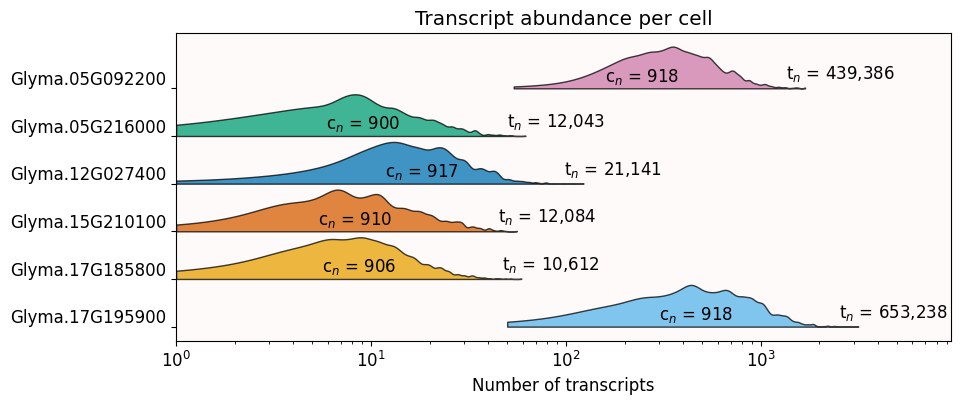

In [4]:
tnmed = 0.15*(tn.max() - tn.min()) #tn.median()

fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_facecolor('snow')
violin = ax[i].violinplot(tn.values, pos, orientation='horizontal', side='high', widths=1.75, showextrema=True, 
                          bw_method=0.1, points=1000, showmeans=False, showmedians=False);
ax[i].set_yticks(pos, [ g.replace('_','.').title() for g in tn.columns], va='bottom')
ax[i].tick_params(labelsize=fs)
ax[i].set_xlabel('Number of transcripts', fontsize=fs)
ax[i].set_title('Transcript abundance per cell', fontsize=1.2*fs)
ax[i].set_xlim(1, 3*tn.max(axis=None))
ax[i].set_xscale('log')
violin['cmaxes'].set_color('k');
violin['cmaxes'].set_lw(0)
violin['cbars'].set_lw(0)
violin['cmins'].set_lw(0)
for j in range(len(pos)):
    ax[i].text(tnmed.iloc[j], 0.05+pos[j], 'c$_n$ = {:d}'.format(tnnz.iloc[j]), ha='center', va='bottom', fontsize=fs)
    ax[i].text(0.8*tnmax.iloc[j], 0.1+pos[j], 't$_n$ = {:,}'.format(tnsum.iloc[j]), ha='left', va='bottom', fontsize=fs)

for j,pc in enumerate(violin['bodies']):
    pc.set_facecolor(color[j])
    pc.set_edgecolor('black')
    pc.set_alpha(0.75)

filename = dst + 'transcript_abundance_per_cell'
#plt.savefig(filename + '.png', format='png', dpi=600, bbox_inches='tight')
#plt.savefig(filename + '.pdf', format='pdf', dpi=200, bbox_inches='tight')

# Cell diversity

In [5]:
from scipy import ndimage
import tifffile as tf
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from KDEpy import FFTKDE

In [7]:
stepsize = 3
pxs = 75
nuclei_mask_cutoff = 1
PP = 6
jsonfoo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
sbkw = dict(label='', size=pxs, loc='upper left', pad=0.5, color='k', frameon=False, size_vertical=7.5)
sbkw1 = dict(label='', size=pxs/stepsize, loc='upper left', pad=0.5, color='lime', frameon=False, size_vertical=7.5/stepsize)
rtkw = dict(ha='right', va='bottom', c='navy', bbox=dict(facecolor='cornsilk', alpha=0.75, boxstyle=mpl.patches.BoxStyle("Square", pad=0.1)))

label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')
wcoords = np.loadtxt(ksrc + sample + '_icoords.csv', delimiter=',', dtype=int)
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)

Detected 2937 cells
Detected 1365 nuclei


In [136]:
normtype = 'both'
exclude_nuclei = True

if exclude_nuclei:
    filenameb = 'os.pardir' + os.sep + 'translocs' + os.sep + sample + os.sep + 'location_corrected_D2_-_{}.csv'
    ex_nuclei = ''
    pdkw = {'header':None, 'names':['X', 'Y', 'Z']}
else:
    filenameb = 'os.pardir' + os.sep + 'Bacteria Info for Erik' + os.sep + '{}_v2.txt'
    ex_nuclei = '_w_nucleus'
    pdkw = {'sep':'\t'}

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata' + ex_nuclei + '.csv', index_col='gene').rename(columns=int)
transcriptomes = np.asarray(transcell.index, dtype=str)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection' + ex_nuclei + '.csv', transcriptomes, startval=0)
translocs = dict()
for key in transcriptomes:
    filename = filenameb.format(key)
    translocs[key] = pd.read_csv(filename, **pdkw)
    translocs[key]['cidx'] = label[ translocs[key]['Y'], translocs[key]['X'] ]
    translocs[key]['nidx'] =  lnuc[ translocs[key]['Y'], translocs[key]['X'] ]
tlocs = pd.concat(translocs)
zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

In [150]:
gidx = 5

transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ gidx ]]), Cells]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')
genes = '_-_'.join(sorted([ g.replace('GLYMA_', 'Glyma.') for g in ratios.index ]))
print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus

Max ratio by both:	5.96%


,169,188,199,209,224,227,233,235,236,243,os.pardir.,2511,2514,2515,2523,2529,2536,2548,2552,2573,2576
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_05G203100,3,21,0,0,0,0,0,3,2,1,os.pardir.,1,0,1,0,13,0,1,0,0,0


In [145]:
bw = 15
SCALE = 48

bname = isrc + '{}_bw{}_{}level'.format(genes.replace('Glyma.',''), bw, level) + os.sep + 'PI_scale{}_'.format(SCALE)
Bname = genes + ' PIs: KDE bandwidth {}. {}level persistence. Scale {}'.format(bw, level.title(), SCALE)
print(bname, Bname, sep='\n')

jsonfiles = dict()
for t in transfocus.index:
    jsonfiles[t] = [ jsonfoo.format(gsrc, t, t, level, PP, stepsize, bw, Cells[i]) for i in range(ratios.shape[1]) ]

orig_diags = utils.get_diagrams(jsonfiles, ndims, remove_inf=True)
diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size); i = 0
for gene in diags:
    for cidx in diags[gene]:
        if len(diags[gene][cidx][2]) > 0:
            kde_max[i] = np.max(diags[gene][cidx][2])
            i += 1
kmax = np.sort(kde_max)[-10]

hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
embedding = pd.read_csv(bname + 'pca.csv')
zero_val = embedding.iloc[-1, 2:].values
zs = [0, 0, zero_val[0], zero_val[1]]
embedding = embedding.iloc[:-1]
pca = embedding.iloc[:,2:4].values

os.pardir/infected_focus_summer24/D2/17G185800_bw15_sublevel/PI_scale48_
Glyma.17G185800 PIs: KDE bandwidth 15. Sublevel persistence. Scale 48
Initial number of life-birth pairs	: 21688

No. of diagrams s.t. H_k had the most persistent component
H_0:	0 [ 0.0% ]
H_1:	0 [ 0.0% ]
H_2:	906 [ 98.7% ]

Will focus just on dimension k = 2



In [146]:
reps_idx = [1,7,12] # 17G195900
reps_idx = [0,6,16] # 05G216000
reps_idx = [0,7,13] # 12G027400
reps_idx = [0,4,12] # 05G216000
#reps_idx = [3,6,15] # 15G210100
reps_idx = [1,6,17] # 17G185800

steps = 2
reps = np.arange(100)
while len(reps) > 20:
    _, _, grid0, minmask0, _ = utils.grid_representatives(pca, pca, steps)
    nrow, ncol, grid, minmask, reps = utils.grid_representatives(grid0[minmask0], pca, steps)
    steps -= 0.05

reps = reps[reps_idx]
Ns = transcell.loc[gene, embedding.loc[reps, 'ndimage_ID'].values].values
argsort = np.argsort(Ns)
Ns = Ns[argsort]; reps = reps[argsort]
rhos = Ns/metacell.loc[embedding.loc[reps, 'ndimage_ID'], 'cyto_area'].values
expo = (np.floor(np.log10(rhos))).astype(int)
base = np.round(rhos*np.power(10., -expo),1)

print(steps, nrow, ncol, len(reps), sep='\t')

0.39999999999999875	5	9	3


In [147]:
hkdes, hcells, hcoords, hextent = [ [None for _ in range(len(reps))] for _ in range(4) ]

for i in range(len(hkdes)):
    gene, cidx = embedding.loc[reps[i], ['gene', 'ndimage_ID']]
    hcoords[i] = translocs[gene].loc[ translocs[gene]['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
    
    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, PP=6)
    s_ = (np.s_[hextent[i][2]:hextent[i][3]], np.s_[hextent[i][0]:hextent[i][1]])
    
    axes, kgrid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], label[s_], hextent[i], zmax, stepsize, cell_nuc, exclude_nuclei=exclude_nuclei)
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(kgrid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
    
    hkdes[i] = np.max(kde * ratios.loc[gene,cidx], axis=0)
    print(i, end=', ')

0, 1, 2, 

os.pardir/manuscript/17G185800_cell_sample.


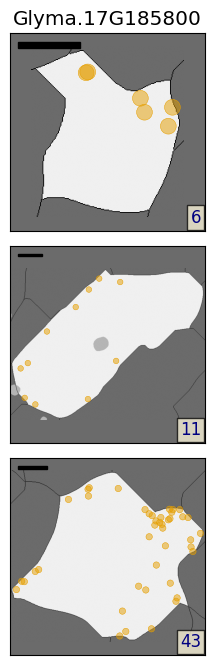

In [148]:
fig, ax = plt.subplots( len(reps), 1, figsize=(2.25, 2.25*len(reps)), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i in range(len(reps)):
    s = int(5e6/hcells[i].size)
    ax[i].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
    ax[i].scatter(*hcoords[i][:2], marker='o', fc=color[dfgene.loc[gene, 'gidx']], ec='none', alpha=min([0.5,75/Ns[i]]) , s=s)
    ax[i].scatter(*hcoords[i][:2], marker='o', fc='none', ec=color[dfgene.loc[gene, 'gidx']], alpha=1 , s=s, lw=0.35)
    ax[i].set_facecolor(wong[2])
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_aspect('equal','datalim')
    ax[i].text(0.98,0.02, Ns[i], transform=ax[i].transAxes, fontsize=fs, **rtkw)
    ax[i].add_artist(AnchoredSizeBar(ax[i].transData, **sbkw))


ax[0].set_title(genes, fontsize=1.2*fs)
fig.tight_layout();
filename = dst + genes.replace('Glyma.','') + '_cell_sample.'
print(filename)
for format in ['png','pdf']:
    plt.savefig(filename + format, dpi=dpi, bbox_inches='tight', format=format)

os.pardir/manuscript/17G185800_kde_sample.


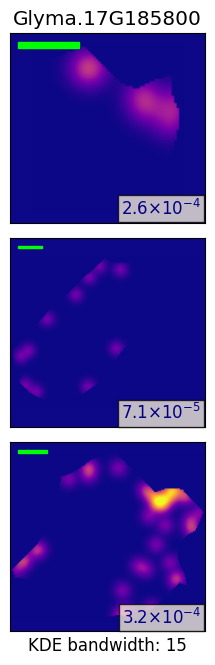

In [149]:
fig, ax = plt.subplots( len(reps), 1, figsize=(2.25, 2.25*len(reps)), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i in range(len(reps)):
    ax[i].imshow(hkdes[i], origin='lower', cmap=Cmap, vmin=0, vmax=kmax, zorder=1)
    ax[i].set_facecolor( mpl.colormaps[Cmap](0) )
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_aspect('equal','datalim')
    ax[i].text(0.98,0.02, '{:.1f}$\\times$10$^{{{}}}$'.format(base[i], expo[i]), fontsize=fs, transform=ax[i].transAxes, **rtkw)
    ax[i].add_artist(AnchoredSizeBar(ax[i].transData, **sbkw1))

ax[0].set_title(genes, fontsize=1.2*fs)
ax[-1].set_xlabel('KDE bandwidth: {}'.format(bw), fontsize=fs)
fig.tight_layout();
filename = dst + genes.replace('Glyma.','') + '_kde_sample.'
print(filename)
for format in ['png','pdf']:
    pass
    plt.savefig(filename + format, dpi=dpi, bbox_inches='tight', format=format)

os.pardir/infected_focus_summer24/D2/05G216000_bw15_sublevel/PI_scale8_H1+2_pca_gridded


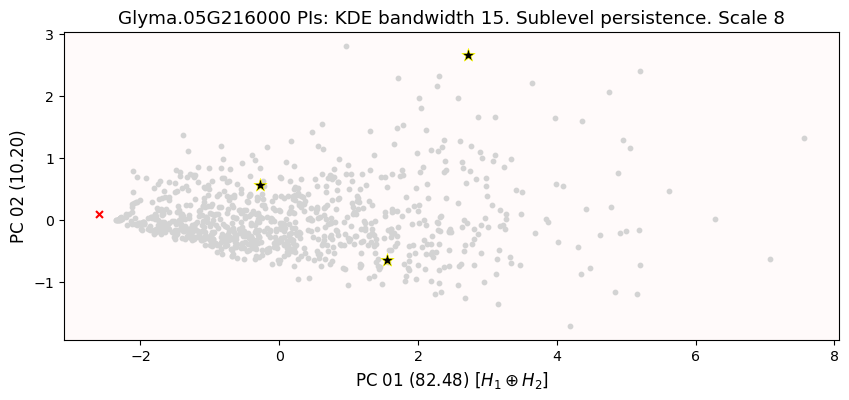

In [114]:
fig, ax = plt.subplots( 1, 1, figsize=(10, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_title(Bname, fontsize=1.1*fs)
ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
#ax[i].scatter(grid[minmask,0], grid[minmask,1], c='b', marker='+', s=25, alpha=1, zorder=2)
ax[i].scatter(*zero_val[:2], c='r', marker='x', s=25, alpha=1, zorder=3)
ax[i].scatter(pca[ reps,0], pca[ reps,1], c='k', marker='*', s=100, alpha=1, zorder=4, edgecolor='yellow', linewidth=0.5)
ax[i].set_xlabel(embedding.columns[2]+Pname, fontsize=fs)
ax[i].set_ylabel(embedding.columns[3], fontsize=fs)
ax[i].tick_params(labelsize=0.85*fs)
ax[i].set_facecolor('snow')
#ax[i].set_aspect('equal')

filename = bname + pname + '_pca_gridded'
print(filename)
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')
#plt.savefig(filename + '.svg', bbox_inches='tight', format='svg')

In [168]:
def clamp(x): 
  return max(0, min(x, 255))

foo = np.linspace(0,1,21)[3]
print(foo)
r,g,b,_ = np.round(np.asarray(mpl.colormaps['viridis'](foo))*255).astype(int)
print(r,g,b)

"#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b)).upper()

0.15000000000000002
70 52 128


'#463480'